## Package import

In [1]:
# for loading the data
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler

# for instantiating the model
import tensorflow as tf
if int(tf.__version__.split(".")[0]) == 2:
    tf.compat.v1.disable_eager_execution()
    from models.tfv2_model_auc_cons import AUCCons
    from models.tfv2_model_ptw_cons import PtwCons
    from models.tfv2_model_other_auc_cons import (AUCConsBNSP,
                                                  AUCConsBPSN,
                                                  AUCConsXAUC)
else:
    from models.model_auc_cons import AUCCons
    from models.model_ptw_cons import PtwCons
    from models.model_other_auc_cons import (AUCConsBNSP,
                                             AUCConsBPSN,
                                             AUCConsXAUC)

# to define a path where the results are saved
import pathlib

# to find out how long the fitting takes
import datetime

# for plotting the ROC curve in the end
import matplotlib.pyplot as plt

**Some general remarks:** I left out all kind of print statements about memory usage as I would like to keep the notebook as slim as possible.

# 1. Compas Dataset

## 1.1 Loading the data

First, we need to define the function that loads the data. That should be load_compas_data() from load_data.py. I just took the relevant code from load_data.py as we don't want all the code for all datasets in here.

In [2]:
TEST_SIZE_COMPAS = 0.2
TEST_SIZE_GERMAN = 0.2

def load_compas_data():
    # See https://www.propublica.org/article/how-we-analyzed-the-compas-recidivism-algorithm
    # Load the two-year data
    df = pd.read_csv('data/compas_data/compas-scores-two-years.csv') # This path got adjusted so that we don't have too many subfolders

    # vr = violent recidivism
    # r = recidivism
    # Types of crimes in the USA: felonies and misdemeanors
    interesting_cols = [  # 'compas_screening_date',
        'sex',  # 'dob',
        'age', 'race',
        'juv_fel_count', 'decile_score', 'juv_misd_count',
        'juv_other_count', 'priors_count',
        'days_b_screening_arrest',
        'c_jail_in', 'c_jail_out',
        'c_charge_degree',
        'is_recid',
        'v_decile_score',
        'decile_score.1',
        ]
    df = df[interesting_cols]
    df = df[np.logical_and(df["days_b_screening_arrest"] >= -30,
                           df["days_b_screening_arrest"] <= 30)]
    df["days_in_jail"] = [a.days for a in (pd.to_datetime(df["c_jail_out"]) -
                                           pd.to_datetime(df["c_jail_in"]))]
    df = df[df["is_recid"] >= 0]
    df = df[df["c_charge_degree"] != "O"]
    # df = df[[x in {"Caucasian", "African-American"} for x in df["race"]]]
    Z = np.array([int(x == "African-American") for x in df["race"]])
    Y = 2*df["is_recid"].values - 1

    cols_to_delete = ["c_jail_out", "c_jail_in", "days_b_screening_arrest"]
    df = df[[a for a in df.columns if a not in cols_to_delete]]

    col_quanti = ["age", "juv_fel_count", "decile_score", "juv_misd_count",
                  "priors_count", "v_decile_score", "decile_score.1",
                  "days_in_jail"]
    col_quali = ["race", "c_charge_degree"]

    X_quali = df[col_quali].values
    X_quanti = df[col_quanti].values

    quali_encoder = OneHotEncoder(categories="auto")
    quali_encoder.fit(X_quali)

    X_quali = quali_encoder.transform(X_quali).toarray()

    X = np.concatenate([X_quanti, X_quali], axis=1)

    X_train, X_test, Y_train, Y_test, Z_train, Z_test = train_test_split(
        X, Y, Z, test_size=TEST_SIZE_COMPAS, random_state=42)

    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    return (X_train, Y_train, Z_train), (X_test, Y_test, Z_test)


def load_adult_dataset():
    # The continuous variable fnlwgt represents final weight, which is the
    # number of units in the target population that the responding unit
    # represents.
    df_train = pd.read_csv("data/adult_dataset/adult.data", header=None)
    columns = ["age", "workclass", "fnlwgt", "education", "education-num",
               "marital-status", "occupation", "relationship", "race", "sex",
               "capital-gain", "capital-loss", "hours-per-week",
               "native-country", "salary"]
    df_train.columns = columns
    df_test = pd.read_csv("data/adult_dataset/adult.test", header=None, comment="|")
    df_test.columns = columns

    def proc_z(Z):
        return np.array([1 if "Male" in z else 0 for z in Z])

    def proc_y(Y):
        return np.array([1 if ">50K" in y else -1 for y in Y])

    Z_train, Z_test = [proc_z(s["sex"]) for s in [df_train, df_test]]
    Y_train, Y_test = [proc_y(s["salary"]) for s in [df_train, df_test]]

    col_quanti = ["age", "education-num", "capital-gain",
                  "capital-loss", "hours-per-week"]  # "fnlwgt",
    col_quali = ["workclass", "education", "marital-status", "occupation",
                 "relationship", "race", "sex", "native-country"]

    X_train_quali = df_train[col_quali].values
    X_test_quali = df_test[col_quali].values

    X_train_quanti = df_train[col_quanti]
    X_test_quanti = df_test[col_quanti]

    quali_encoder = OneHotEncoder(categories="auto")  # drop="first")
    quali_encoder.fit(X_train_quali)

    X_train_quali_enc = quali_encoder.transform(X_train_quali).toarray()
    X_test_quali_enc = quali_encoder.transform(X_test_quali).toarray()

    X_train = np.concatenate([X_train_quali_enc, X_train_quanti], axis=1)
    X_test = np.concatenate([X_test_quali_enc, X_test_quanti], axis=1)

    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    return (X_train, Y_train, Z_train), (X_test, Y_test, Z_test)


def load_german_data():
    def preprocess_z(x):
        assert x in {"A91", "A92", "A93", "A94", "A95"}
        if x in {"A91", "A93", "A94"}:
            return 1
        else:
            return 0

    def preprocess_y(x):
        assert x in {1, 2}
        return 2*int(x == 1) - 1

    # Generates a dataset with 48 covariates with
    df = pd.read_csv("data/german_credit_data/german.data", sep=" ",
                     header=None)
    df.columns = ["check account", "duration", "credit history", "purpose",
                  "credit amount", "savings/bonds", "employed since",
                  "installment rate", "status and sex",
                  "other debtor/guarantor", "residence since", "property",
                  "age", "other plans", "housing", "existing credits",
                  "job", "number liable people", "telephone",
                  "foreign worker", "credit decision"]
    ind_sex = 8
    Z = np.array([preprocess_z(x) for x in df[df.columns[ind_sex]]])
    Y = np.array([preprocess_y(x) for x in df[df.columns[-1]]])

    cols_X = df.columns[:-1]
    ind_quali = {0, 2, 3, 5, 6, 8, 9, 11, 13, 14, 16, 18, 19}
    ind_all = set(range(len(cols_X)))

    X_quanti = df[df.columns[list(ind_all.difference(ind_quali))]].values

    X_quali = df[df.columns[list(ind_quali)]].values

    quali_encoder = OneHotEncoder(categories="auto")
    quali_encoder.fit(X_quali)
    X_quali = quali_encoder.transform(X_quali).toarray()

    X = np.concatenate([X_quanti, X_quali], axis=1)

    X_train, X_test, Z_train, Z_test, Y_train, Y_test = train_test_split(
        X, Z, Y, test_size=TEST_SIZE_GERMAN, random_state=42)

    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    return (X_train, Y_train, Z_train), (X_test, Y_test, Z_test)

# In the following function, I removed all the other datasets as we're just trying out the compas dataset here
def load_db_by_name(db_name):
    if db_name == "german":
        return load_german_data()
    elif db_name == "adult":
        return load_adult_dataset()
    elif db_name == "compas":
        return load_compas_data()
    raise ValueError("Wrong db name...")

I'm just testing shortly whether the above defined functions work. --> It looks like it does.

In [3]:
time_1 = datetime.datetime.now()

data_train, data_test = load_db_by_name("compas")
X_train, Y_train, Z_train = data_train
X_test, Y_test, Z_test = data_test

# Print the first few rows of each part of the data to verify it's loaded correctly
print("First few rows of X_train:")
print(X_train[:3])

print("\nFirst few values of Z_train (sensitive attributes):")
print(Z_train[:3])

print("\nFirst few labels of y_train:")
print(Y_train[:3])

print("\nFirst few rows of X_test:")
print(X_test[:3])

print("\nFirst few values of Z_test (sensitive attributes):")
print(Z_test[:3])

print("\nFirst few labels of y_test:")
print(Y_test[:3])


First few rows of X_train:
[[ 0.45923617 -0.1257918  -1.20229829 -0.18721999 -0.69278746 -1.05870501
  -1.20229829 -0.3137581  -1.03820131 -0.07552357  1.41206789 -0.30054426
  -0.04028706 -0.24613009 -1.35248895  1.35248895]
 [-0.82140605 -0.1257918  -0.14667911 -0.18721999 -0.4813843  -0.25612127
  -0.14667911 -0.29195745 -1.03820131 -0.07552357 -0.70818125 -0.30054426
  -0.04028706  4.0628921   0.73937757 -0.73937757]
 [ 0.11773158 -0.1257918   0.55706701 -0.18721999  1.63264728  0.14517061
   0.55706701 -0.27015679 -1.03820131 -0.07552357  1.41206789 -0.30054426
  -0.04028706 -0.24613009 -1.35248895  1.35248895]]

First few values of Z_train (sensitive attributes):
[0 0 0]

First few labels of y_train:
[-1  1  1]

First few rows of X_test:
[[-0.7360299  -0.1257918   1.96455926 -0.18721999  2.0554536   2.55292183
   1.96455926 -0.16115352  0.96320434 -0.07552357 -0.70818125 -0.30054426
  -0.04028706 -0.24613009 -1.35248895  1.35248895]
 [-0.30914916 -0.1257918  -0.49855217  1.857702

## 1.2 Defining a method to get an instance of the model

Next in the fit.py script of the paper's repo, there's load_model() function which is called from the utils.py file. According to utils.py, this function returns and instantiation of the model.

For example acc. to model_auc_cons.py, we don't necessary need to hand over param_files when calling the load_model function as there are some default values defines in the model classes. We could adjust the parameter.

In [4]:
# Taking the relevant code for intantiating the model

# define a dictionary, mapping of model type identifiers to their corresponding class definitions
MODEL_PATH_TO_CLASS = {"auc_cons": AUCCons,
                       "auc_cons_bnsp": AUCConsBNSP,
                       "auc_cons_bpsn": AUCConsBPSN,
                       "auc_cons_xauc": AUCConsXAUC,
                       "ptw_cons": PtwCons}

def load_model(model_name, param_files=None):
    """Returns an instantiation of the model."""
    return MODEL_PATH_TO_CLASS[model_name](param_files=param_files)

## 1.3 Instantiating a BPSN model

A BPSN model is a model with an AUC-based fairness constraint. Let's try to load one.

In [5]:
bpsn_model = load_model("auc_cons_bpsn")

Parameters:
n_iter : 150000
n_batch : 1000
display_step : 500
lr : 0.001
adapt_step : 0.01
momentum : 0.9
default_c : 0.0
default_var_init : 0.01
reg : 0.001
optimizer : momentum
weight_fun : softmax
cooling_c : 0
balanced : 0
validation_size : 0.1
coef_lagrange : 1.0
net_depth : 3
use_inc_auc_train : 1
n_incomplete_train : 1000
use_inc_auc_valid : 1
n_incomplete_valid : 10000
c : 0.0


Next, we hardcode a folder where the results are saved

In [6]:
# we hardcode a folder where the results are saved
exp_path = pathlib.Path("./output")

if not exp_path.exists():
    exp_path.mkdir()

## 1.4 Fitting the data to the BPSN model

In [7]:
# need to close an eventually already existing tenserflow session properly as we can't fit another model otherwise
tf.compat.v1.reset_default_graph()

time_2 = datetime.datetime.now()
bpsn_model.fit(data_train) # I didn't include the optional parameter about the model folder as I just created a new instance.
time_3 = datetime.datetime.now()

Number of features: 16
Size of the train set: 4443
Size of the validation set: 494
Instructions for updating:
Colocations handled automatically by placer.


/opt/anaconda3/envs/fml_tf_env_v2/lib/python3.8/site-packages/keras/legacy_tf_layers/normalization.py:423: UserWarning: `tf.layers.batch_normalization` is deprecated and will be removed in a future version. Please use `tf.keras.layers.BatchNormalization` instead. In particular, `tf.control_dependencies(tf.GraphKeys.UPDATE_OPS)` should not be used (consult the `tf.keras.layers.BatchNormalization` documentation).
  warnings.warn(
/opt/anaconda3/envs/fml_tf_env_v2/lib/python3.8/site-packages/keras/engine/base_layer_v1.py:1676: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


dt |  r_cost  |   cost   |   auc    |  r_auc   |  f_auc   | r_f_auc  |    l2    |    c    
tr | +0.50004 | +0.02400 | +0.38700 | +0.50000 | -0.36300 | -0.00000 | +0.03947 | +0.00000
te | +0.50004 | +0.03565 | +0.38630 | +0.50000 | -0.35065 | +0.00000 | +0.03947 | +0.00000
Iter   0   ---------- 9/5/24 - 12:20:19 -----


2024-05-09 12:20:19.198122: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


dt |  r_cost  |   cost   |   auc    |  r_auc   |  f_auc   | r_f_auc  |    l2    |    c    
tr | +0.50004 | +0.06000 | +0.36900 | +0.50000 | -0.30900 | -0.00000 | +0.03918 | -0.01000
te | +0.50004 | +0.02100 | +0.33745 | +0.50000 | -0.31645 | -0.00000 | +0.03918 | -0.01000
Iter  500  ---------- 9/5/24 - 12:20:19 -----
dt |  r_cost  |   cost   |   auc    |  r_auc   |  f_auc   | r_f_auc  |    l2    |    c    
tr | +0.50004 | -0.05400 | +0.29000 | +0.50000 | -0.34400 | -0.00000 | +0.03894 | -0.02000
te | +0.50004 | +0.00385 | +0.29465 | +0.50000 | -0.29080 | -0.00000 | +0.03894 | -0.02000
Iter 1000  ---------- 9/5/24 - 12:20:20 -----
dt |  r_cost  |   cost   |   auc    |  r_auc   |  f_auc   | r_f_auc  |    l2    |    c    
tr | +0.50004 | +0.08650 | +0.27450 | +0.50000 | -0.18800 | -0.00000 | +0.03879 | -0.03000
te | +0.50004 | +0.03170 | +0.27775 | +0.50000 | -0.24605 | -0.00000 | +0.03879 | -0.03000
Iter 1500  ---------- 9/5/24 - 12:20:20 -----
dt |  r_cost  |   cost   |   auc    |  r_au

After fitting the model, we can simply output some information and save the model to the defined folder.

In [8]:
# Write a logging file with important info
with (exp_path / "log.txt").open("wt") as f:
    f.write("db_name: {}\n".format("compas"))
    f.write("time_to_load: {}\n".format(time_2-time_1))
    f.write("time_to_fit: {}\n".format(time_3-time_2))

# Save the model
bpsn_model.save_model(exp_path)

## 1.5 Evaluation

In [9]:
s_test = np.array(bpsn_model.score(X_test)).ravel().astype(float)
s_train = np.array(bpsn_model.score(X_train)).ravel().astype(float)

# Define a path on where to save the results
path_analysis = pathlib.Path("./evaluation")

if not path_analysis.exists():
        path_analysis.mkdir()

The following code is taken from ./more_utils/roc_calculus.py

In [10]:
def fpr_tpr(scores, classes):
    """
        Computes the ROC curves from scores and classes of comparisons.
        Does not work if the distributions of the scores are not continuous.
    """
    scores = np.array(scores)
    classes = (np.array(classes) == +1).astype(int)

    n_pos = classes.sum()
    n_neg = classes.shape[0] - n_pos

    ind_sort = np.argsort(scores)  # argsort, increasing order
    cl_sort = classes[ind_sort]

    fnr_ar = cl_sort.cumsum()/n_pos
    tnr_ar = (1-cl_sort).cumsum()/n_neg
    fpr_ar = 1 - tnr_ar

    return fpr_ar, 1 - fnr_ar

def auc(scores, classes, B=None):
    if B is None:
        s = scores.reshape((-1, 1))
        y = classes.reshape((-1, 1))
        ind_0, ind_1 = np.where((y-y.transpose()) > 0)
        delta_s = s[ind_0] - s[ind_1]
    else:
        s = scores
        y = classes
        f_p = (y == 1)
        s_p, s_n = s[f_p], s[~f_p]
        delta_s = np.random.choice(s_p, B) - np.random.choice(s_n, B)
    return (delta_s > 0).mean() + 0.5*(delta_s == 0).mean()

The following code is taken from ./more_utils/roc_plot.py and adjusted by leaving out unnecessary parts.

In [11]:
LEGEND_SIZE = (5.2, 1)


class RocGen:
    def __init__(self, s_1, s_2, out_fold):
        self.s_1 = s_1
        self.s_2 = s_2
        self.out_fold = out_fold
        self.prefix = ""

    def save_roc(self, fpr, tpr):
        fold = pathlib.Path("{}/{}".format(self.out_fold, "rocs"))
        if not fold.exists():
            fold.mkdir()
        path = fold/("{}".format(self.prefix))
        with open(str(path) + "fpr.npy", "wb") as f:
            np.save(f, fpr)
        with open(str(path) + "tpr.npy", "wb") as f:
            np.save(f, tpr)


class RocGenSec3(RocGen):
    def f_1(self, y, z):
        return z == 0

    def f_2(self, y, z):
        return z == 1

    def y_1(self, y, z):
        return y[self.f_1(y, z)]

    def y_2(self, y, z):
        return y[self.f_2(y, z)]


class RocGenSec4(RocGen):
    def f_1(self, y, z):
        return y != 1

    def f_2(self, y, z):
        return y == 1

    def y_1(self, y, z):
        return z[self.f_1(y, z)]

    def y_2(self, y, z):
        return z[self.f_2(y, z)]


def plot_roc(s, y, z, rocgen, ls="-"):
    fpr, tpr = fpr_tpr(s, y)

    fpr_1, tpr_1 = fpr_tpr(s[rocgen.f_1(y, z)], rocgen.y_1(y, z))
    fpr_2, tpr_2 = fpr_tpr(s[rocgen.f_2(y, z)], rocgen.y_2(y, z))
    fpr, tpr = fpr_tpr(s, y)

    plt.plot(fpr_1, tpr_1, label=rocgen.s_1, color="green", linestyle=ls)
    plt.plot(fpr_2, tpr_2, label=rocgen.s_2, color="blue", linestyle=ls)
    plt.plot(fpr, tpr, label="$ROC_{H_s, G_s}$", color="black", linestyle=ls)

    orig_prefix = rocgen.prefix
    rocgen.prefix = orig_prefix + "-1-"
    rocgen.save_roc(fpr_1, tpr_1)
    rocgen.prefix = orig_prefix + "-2-"
    rocgen.save_roc(fpr_2, tpr_2)
    rocgen.prefix = orig_prefix + "-main-"
    rocgen.save_roc(fpr, tpr)


def legend_get_handles(ls="-"):
    handles = list()
    for color in ["green", "blue", "black"]:
        handles.append(plt.Line2D([0], [0], color=color, linestyle=ls))
    return handles


def plot_roc_sec3(path_analysis, data_train, data_test, save_data=True):
    s_train, y_train, Z_train = data_train
    s_test, y_test, Z_test = data_test

    plt.figure(figsize=(7, 7))

    s_1 = "$ROC_{H_s^{(0)}, G_s^{(0)}}$"
    s_2 = "$ROC_{H_s^{(1)}, G_s^{(1)}}$"
    rocgen = RocGenSec3(s_1, s_2, path_analysis)
    rocgen.prefix = "sec3-test"
    plot_roc(s_test, y_test, Z_test, rocgen)
    # rocgen.prefix = "sec3-train"
    # plot_roc(s_train, y_train, Z_train, rocgen, ls="--")

    plt.xlabel("$FPR$")
    plt.ylabel("$TPR$")
    plt.grid()
    plt.tight_layout()
    plt.savefig(path_analysis/"roc_sec3.pdf")

    plt.figure(figsize=LEGEND_SIZE)
    labels = [s_1, s_2, "$ROC_{H_s, G_s}$"]
    # leg = plt.legend(legend_get_handles("--"), labels, title="Train",
    #                  ncol=3, loc="center left")
    leg = plt.legend(legend_get_handles("-"), labels, title="Test",
               ncol=3, loc="center right") # added the leg = here in the beginning
    plt.gca().axis('off')
    plt.gca().add_artist(leg)
    plt.savefig(path_analysis/"leg_sec3.pdf")

    try:
        # Attempt to calculate the AUC and print it (doesn't seem to work if there are too little examples like in the german credit dataset)
        print(f"The AUC for the test (black ROC curve) set is: {auc(s_test, y_test):.3f}")
    except Exception as e:
        pass 


def plot_roc_sec4(path_analysis, data_train, data_test, save_data=True):
    s_train, y_train, Z_train = data_train
    s_test, y_test, Z_test = data_test

    plt.figure(figsize=(7, 7))

    plt.plot([0, 1], [0, 1], color="grey")
    s_1, s_2 = "$ROC_{H_s^{(0)}, H_s^{(1)}}$", "$ROC_{G_s^{(0)}, G_s^{(1)}}$"
    rocgen = RocGenSec4(s_1, s_2, path_analysis)
    rocgen.prefix = "sec4-test"
    plot_roc(s_test, y_test, Z_test, rocgen)
    # rocgen.prefix = "sec4-train"
    # plot_roc(s_train, y_train, Z_train, rocgen, ls="--")

    plt.xlabel("$FPR$")
    plt.ylabel("$TPR$")
    plt.grid()
    plt.tight_layout()
    plt.savefig(path_analysis/"roc_sec4.pdf")

    plt.figure(figsize=LEGEND_SIZE)
    labels = [s_1, s_2, "$ROC_{H_s, G_s}$"]
    # leg = plt.legend(legend_get_handles("--"), labels, title="Train",
    #                  ncol=3, loc="center left") # added the leg = here in the beginning
    leg = plt.legend(legend_get_handles("-"), labels, title="Test",
               ncol=3, loc="center right")
    plt.gca().axis('off')
    plt.gca().add_artist(leg)
    plt.savefig(path_analysis/"leg_sec4.pdf")

The AUC for the test (black ROC curve) set is: 0.693


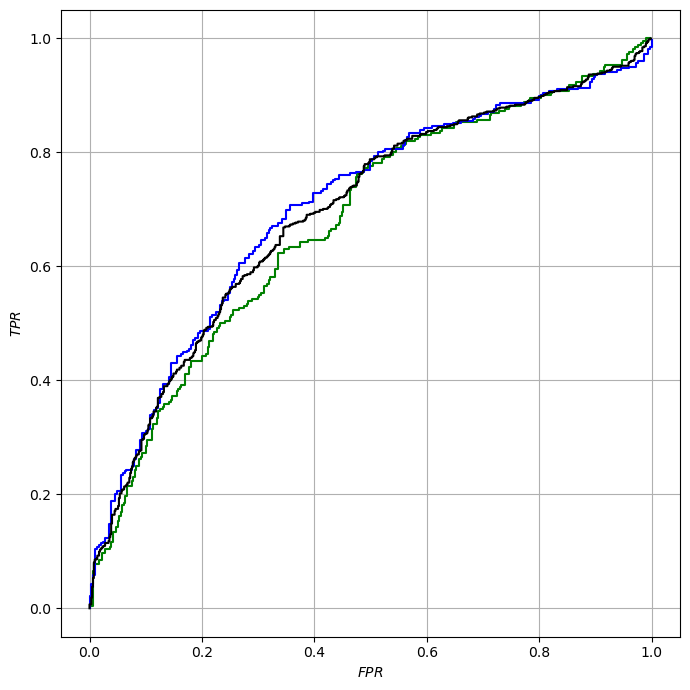

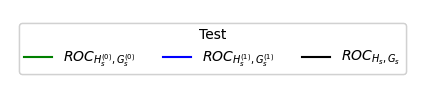

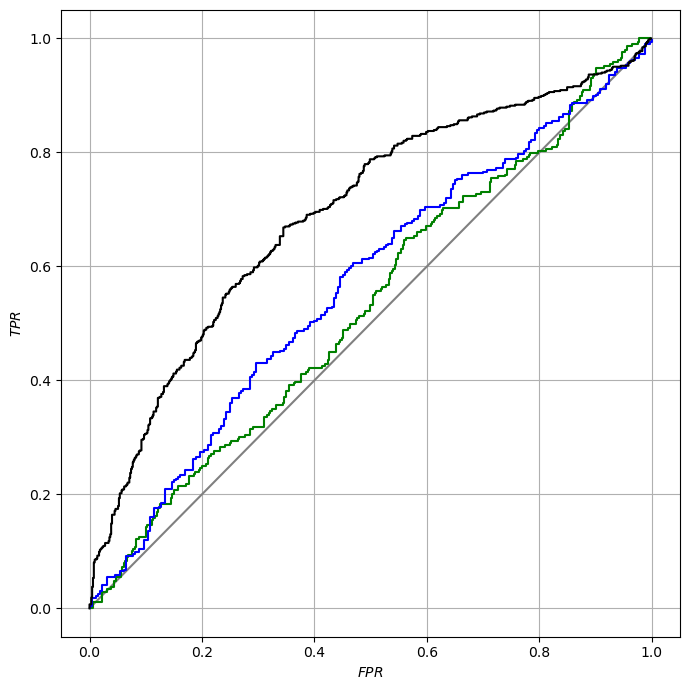

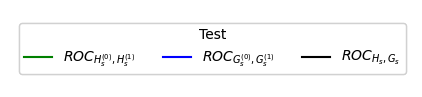

In [12]:
# 1. Plot ROC curves for all problems on the same plot
plot_roc_sec3(path_analysis,
                (s_train, Y_train, Z_train), (s_test, Y_test, Z_test))

# 2. Other view on ROCs
plot_roc_sec4(path_analysis,
                (s_train, Y_train, Z_train), (s_test, Y_test, Z_test))

## 1.6 Trying to learn a scoring function with ROC-based fairness constraint

In [13]:
roc_model = load_model("ptw_cons")

Parameters:
mon_pts : {-1: [0.25], 1: [0.25]}
adapt_step_t : 0.01
n_iter : 150000
n_batch : 1000
display_step : 500
lr : 0.001
adapt_step : 0.01
momentum : 0.9
default_c : 0.0
default_var_init : 0.01
reg : 0.001
optimizer : momentum
weight_fun : softmax
cooling_c : 0
balanced : 0
validation_size : 0.1
coef_lagrange : 1.0
net_depth : 3
use_inc_auc_train : 1
n_incomplete_train : 1000
use_inc_auc_valid : 1
n_incomplete_valid : 10000
c : 0.0


In [14]:
# we hardcode a folder where the results are saved
exp_path = pathlib.Path("./output")

if not exp_path.exists():
    exp_path.mkdir()

In [15]:
# need to close an eventually already existing tenserflow session properly as we can't fit another model otherwise
tf.compat.v1.reset_default_graph()

time_2 = datetime.datetime.now()
roc_model.fit(data_train) # I didn't include the optional parameter about the model folder as I just created a new instance.
time_3 = datetime.datetime.now()

Number of features: 16
Size of the train set: 4443
Size of the validation set: 494


/opt/anaconda3/envs/fml_tf_env_v2/lib/python3.8/site-packages/keras/legacy_tf_layers/normalization.py:423: UserWarning: `tf.layers.batch_normalization` is deprecated and will be removed in a future version. Please use `tf.keras.layers.BatchNormalization` instead. In particular, `tf.control_dependencies(tf.GraphKeys.UPDATE_OPS)` should not be used (consult the `tf.keras.layers.BatchNormalization` documentation).
  warnings.warn(
/opt/anaconda3/envs/fml_tf_env_v2/lib/python3.8/site-packages/keras/engine/base_layer_v1.py:1676: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


dt |  r_cost  |   cost   |   auc    |  r_auc   |    l2    |  mean_c  |  var_c   |  dFPR_m  |  dFPR_v  |  dTPR_m  |  dTPR_v 
tr | +0.50004 | +0.32500 | +0.32500 | +0.50000 | +0.03952 | +0.00000 | +0.00000 | +0.75000 | +0.00000 | +0.75000 | +0.00000
te | +0.50004 | +0.35760 | +0.35760 | +0.50000 | +0.03952 | +0.00000 | +0.00000 | +0.75000 | +0.00000 | +0.75000 | +0.00000
c: +0.00000 | +0.00000
biases: +0.00000 | +0.00000
FPRs: +1.00000 | +1.00000
TPRs: +1.00000 | +1.00000
Iter   0   ---------- 9/5/24 - 12:22:22 -----
dt |  r_cost  |   cost   |   auc    |  r_auc   |    l2    |  mean_c  |  var_c   |  dFPR_m  |  dFPR_v  |  dTPR_m  |  dTPR_v 
tr | +0.50004 | +0.33200 | +0.33200 | +0.50000 | +0.03919 | +0.00000 | +0.00000 | +0.25000 | +0.00000 | +0.25000 | +0.00000
te | +0.50004 | +0.34630 | +0.34630 | +0.50000 | +0.03919 | +0.00000 | +0.00000 | +0.25000 | +0.00000 | +0.25000 | +0.00000
c: +0.00000 | +0.00000
biases: +0.01000 | +0.01000
FPRs: +0.00000 | +0.00000
TPRs: +0.00000 | +0.00000
Iter

In [16]:
# Write a logging file with important info
with (exp_path / "log.txt").open("wt") as f:
    f.write("db_name: {}\n".format("compas"))
    f.write("time_to_load: {}\n".format(time_2-time_1))
    f.write("time_to_fit: {}\n".format(time_3-time_2))

# Save the model
roc_model.save_model(exp_path)

In [17]:
s_test = np.array(roc_model.score(X_test)).ravel().astype(float)
s_train = np.array(roc_model.score(X_train)).ravel().astype(float)

# Define a path on where to save the results
path_analysis = pathlib.Path("./evaluation")

if not path_analysis.exists():
        path_analysis.mkdir()

The AUC for the test (black ROC curve) set is: 0.688


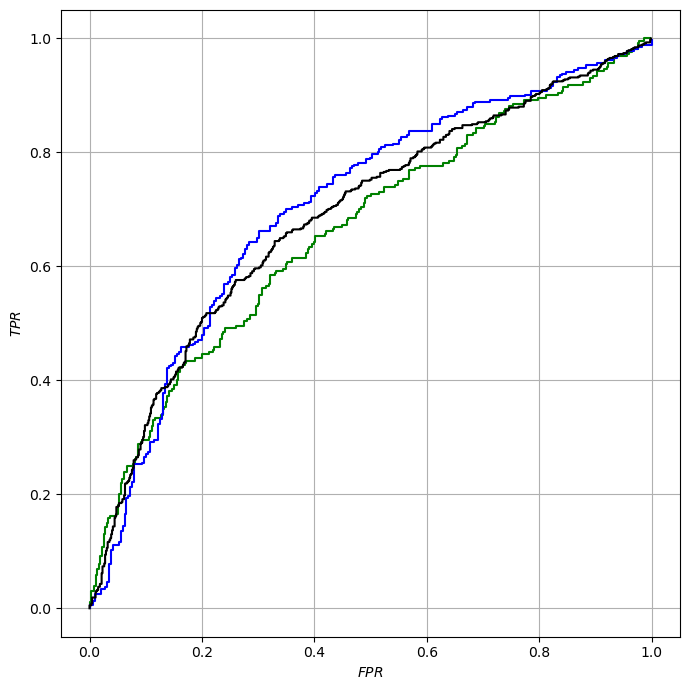

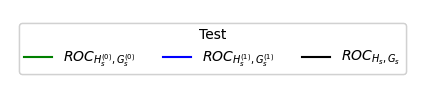

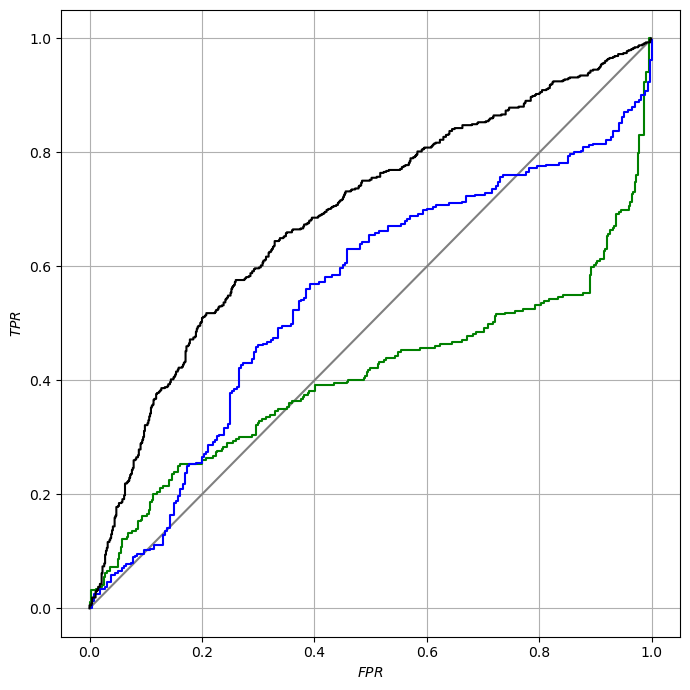

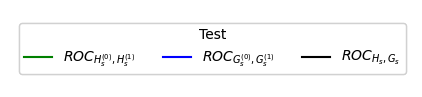

In [18]:
# 1. Plot ROC curves for all problems on the same plot
plot_roc_sec3(path_analysis,
                (s_train, Y_train, Z_train), (s_test, Y_test, Z_test))

# 2. Other view on ROCs
plot_roc_sec4(path_analysis,
                (s_train, Y_train, Z_train), (s_test, Y_test, Z_test))

# 2. Adult dataset

In [19]:
time_1 = datetime.datetime.now()

data_train, data_test = load_db_by_name("adult")
X_train, Y_train, Z_train = data_train
X_test, Y_test, Z_test = data_test

# Print the first few rows of each part of the data to verify it's loaded correctly
print("First few rows of X_train:")
print(X_train[:3])

print("\nFirst few values of Z_train (sensitive attributes):")
print(Z_train[:3])

print("\nFirst few labels of y_train:")
print(Y_train[:3])

print("\nFirst few rows of X_test:")
print(X_test[:3])

print("\nFirst few values of Z_test (sensitive attributes):")
print(Z_test[:3])

print("\nFirst few labels of y_test:")
print(Y_test[:3])

First few rows of X_train:
[[-0.2444502  -0.17429511 -0.26209736 -0.01466381 -1.5167923  -0.18838933
  -0.29093568  4.90769968 -0.02073999 -0.17175325 -0.19348662 -0.11609195
  -0.07201601 -0.10164955 -0.1422718  -0.12664495 -0.18406376 -0.21053433
   2.25399324 -0.11334387 -0.68994199 -0.23637391 -0.03960742 -0.13419553
  -0.53714425 -0.39750806 -0.02658695 -0.92284068 -0.11403678  1.43105786
  -0.1802846  -0.17735813 -0.24494366  2.76348874 -0.01662771 -0.37949517
  -0.37774555 -0.17745022 -0.20957797 -0.25595432 -0.33554133 -0.06780164
  -0.38166338 -0.14260848 -0.35531609 -0.17127887 -0.22710355 -0.82533335
   1.70899099 -0.17624972 -0.42934582 -0.34403232 -0.22492681 -0.09820087
  -0.18155194 -0.32576824 -0.09161163  0.4130197  -0.70307135  0.70307135
  -0.13502327 -0.02416321 -0.06107342 -0.0480488  -0.04260602 -0.05409379
  -0.04641598 -0.02933708 -0.05714946 -0.05264698 -0.02985682 -0.06500204
  -0.02985682 -0.04437806 -0.03678503 -0.00554189 -0.01998525 -0.02479131
  -0.019985

## 2.1 Inter-group pairwise AUC fairness

Parameters:
n_iter : 150000
n_batch : 1000
display_step : 500
lr : 0.001
adapt_step : 0.01
momentum : 0.9
default_c : 0.0
default_var_init : 0.01
reg : 0.001
optimizer : momentum
weight_fun : softmax
cooling_c : 0
balanced : 0
validation_size : 0.1
coef_lagrange : 1.0
net_depth : 3
use_inc_auc_train : 1
n_incomplete_train : 1000
use_inc_auc_valid : 1
n_incomplete_valid : 10000
c : 0.0
Number of features: 107
Size of the train set: 29304
Size of the validation set: 3257


/opt/anaconda3/envs/fml_tf_env_v2/lib/python3.8/site-packages/keras/legacy_tf_layers/normalization.py:423: UserWarning: `tf.layers.batch_normalization` is deprecated and will be removed in a future version. Please use `tf.keras.layers.BatchNormalization` instead. In particular, `tf.control_dependencies(tf.GraphKeys.UPDATE_OPS)` should not be used (consult the `tf.keras.layers.BatchNormalization` documentation).
  warnings.warn(
/opt/anaconda3/envs/fml_tf_env_v2/lib/python3.8/site-packages/keras/engine/base_layer_v1.py:1676: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


dt |  r_cost  |   cost   |   auc    |  r_auc   |  f_auc   | r_f_auc  |    l2    |    c    
tr | +0.50176 | +0.26900 | +0.45000 | +0.50000 | -0.18100 | -0.00001 | +1.75897 | +0.00000
te | +0.50175 | +0.31740 | +0.40870 | +0.49999 | -0.09130 | -0.00001 | +1.75897 | +0.00000
Iter   0   ---------- 9/5/24 - 12:24:17 -----
dt |  r_cost  |   cost   |   auc    |  r_auc   |  f_auc   | r_f_auc  |    l2    |    c    
tr | +0.46217 | -0.08600 | +0.09700 | +0.45967 | -0.18300 | -0.02824 | +2.22095 | -0.01000
te | +0.46233 | -0.08660 | +0.09810 | +0.45985 | -0.18470 | -0.02631 | +2.22095 | -0.01000
Iter  500  ---------- 9/5/24 - 12:24:18 -----
dt |  r_cost  |   cost   |   auc    |  r_auc   |  f_auc   | r_f_auc  |    l2    |    c    
tr | +0.43055 | -0.08050 | +0.10350 | +0.42722 | -0.18400 | -0.04513 | +2.42922 | -0.02000
te | +0.42978 | -0.04800 | +0.09170 | +0.42663 | -0.13970 | -0.03627 | +2.42922 | -0.02000
Iter 1000  ---------- 9/5/24 - 12:24:19 -----
dt |  r_cost  |   cost   |   auc    |  r_au

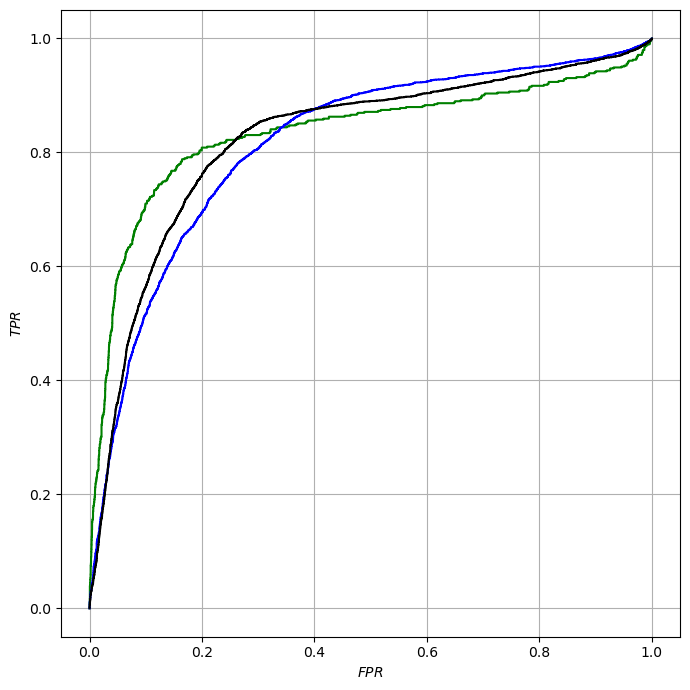

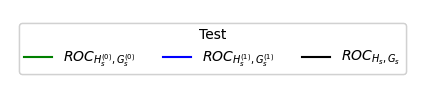

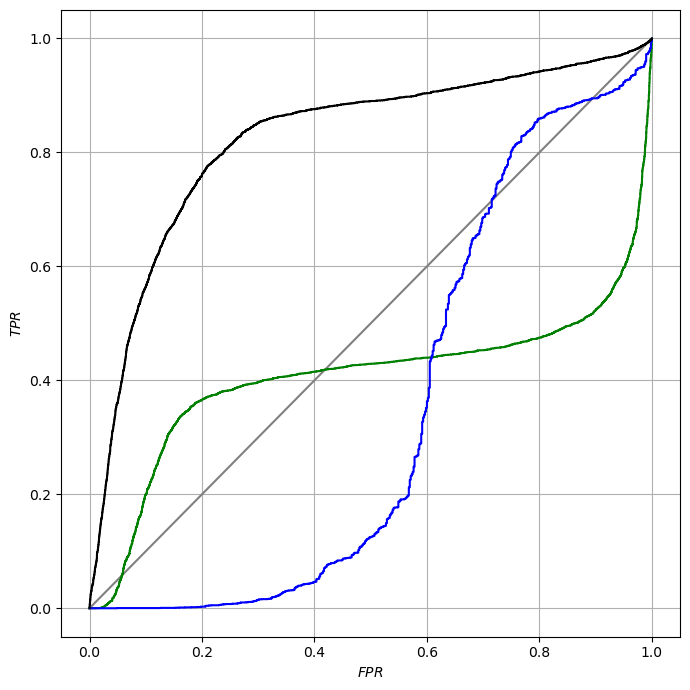

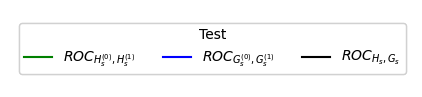

In [20]:
xauc_model = load_model("auc_cons_xauc")

# we hardcode a folder where the results are saved
exp_path = pathlib.Path("./output")

if not exp_path.exists():
    exp_path.mkdir()

# need to close an eventually already existing tenserflow session properly as we can't fit another model otherwise
tf.compat.v1.reset_default_graph()

time_2 = datetime.datetime.now()
xauc_model.fit(data_train) # I didn't include the optional parameter about the model folder as I just created a new instance.
time_3 = datetime.datetime.now()

# Write a logging file with important info
with (exp_path / "log.txt").open("wt") as f:
    f.write("db_name: {}\n".format("adult"))
    f.write("time_to_load: {}\n".format(time_2-time_1))
    f.write("time_to_fit: {}\n".format(time_3-time_2))

# Save the model
xauc_model.save_model(exp_path)

s_test = np.array(xauc_model.score(X_test)).ravel().astype(float)
s_train = np.array(xauc_model.score(X_train)).ravel().astype(float)

# Define a path on where to save the results
path_analysis = pathlib.Path("./evaluation")

if not path_analysis.exists():
        path_analysis.mkdir()

# 1. Plot ROC curves for all problems on the same plot
plot_roc_sec3(path_analysis,
                (s_train, Y_train, Z_train), (s_test, Y_test, Z_test))

# 2. Other view on ROCs
plot_roc_sec4(path_analysis,
                (s_train, Y_train, Z_train), (s_test, Y_test, Z_test))

## 2.2 ROC based fairness

Parameters:
mon_pts : {-1: [0.25], 1: [0.25]}
adapt_step_t : 0.01
n_iter : 150000
n_batch : 1000
display_step : 500
lr : 0.001
adapt_step : 0.01
momentum : 0.9
default_c : 0.0
default_var_init : 0.01
reg : 0.001
optimizer : momentum
weight_fun : softmax
cooling_c : 0
balanced : 0
validation_size : 0.1
coef_lagrange : 1.0
net_depth : 3
use_inc_auc_train : 1
n_incomplete_train : 1000
use_inc_auc_valid : 1
n_incomplete_valid : 10000
c : 0.0
Number of features: 107
Size of the train set: 29304
Size of the validation set: 3257


/opt/anaconda3/envs/fml_tf_env_v2/lib/python3.8/site-packages/keras/legacy_tf_layers/normalization.py:423: UserWarning: `tf.layers.batch_normalization` is deprecated and will be removed in a future version. Please use `tf.keras.layers.BatchNormalization` instead. In particular, `tf.control_dependencies(tf.GraphKeys.UPDATE_OPS)` should not be used (consult the `tf.keras.layers.BatchNormalization` documentation).
  warnings.warn(
/opt/anaconda3/envs/fml_tf_env_v2/lib/python3.8/site-packages/keras/engine/base_layer_v1.py:1676: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


dt |  r_cost  |   cost   |   auc    |  r_auc   |    l2    |  mean_c  |  var_c   |  dFPR_m  |  dFPR_v  |  dTPR_m  |  dTPR_v 
tr | +0.50174 | +0.47500 | +0.47500 | +0.50000 | +1.74370 | +0.00000 | +0.00000 | +0.75000 | +0.00000 | +0.75000 | +0.00000
te | +0.50175 | +0.53650 | +0.53650 | +0.50000 | +1.74370 | +0.00000 | +0.00000 | +0.75000 | +0.00000 | +0.75000 | +0.00000
c: +0.00000 | +0.00000
biases: +0.00000 | +0.00000
FPRs: +1.00000 | +1.00000
TPRs: +1.00000 | +1.00000
Iter   0   ---------- 9/5/24 - 12:30:16 -----
dt |  r_cost  |   cost   |   auc    |  r_auc   |    l2    |  mean_c  |  var_c   |  dFPR_m  |  dFPR_v  |  dTPR_m  |  dTPR_v 
tr | +0.47116 | +0.11300 | +0.11300 | +0.46901 | +2.15266 | +0.00000 | +0.00000 | +0.34982 | +0.03805 | +0.48093 | +0.05384
te | +0.46962 | +0.10570 | +0.10570 | +0.46747 | +2.15266 | +0.00000 | +0.00000 | +0.32649 | +0.04831 | +0.46659 | +0.05905
c: +0.00000 | +0.00000
biases: +0.01000 | +0.01000
FPRs: +0.14331 | +0.79630
TPRs: +0.47358 | +0.95960
Iter

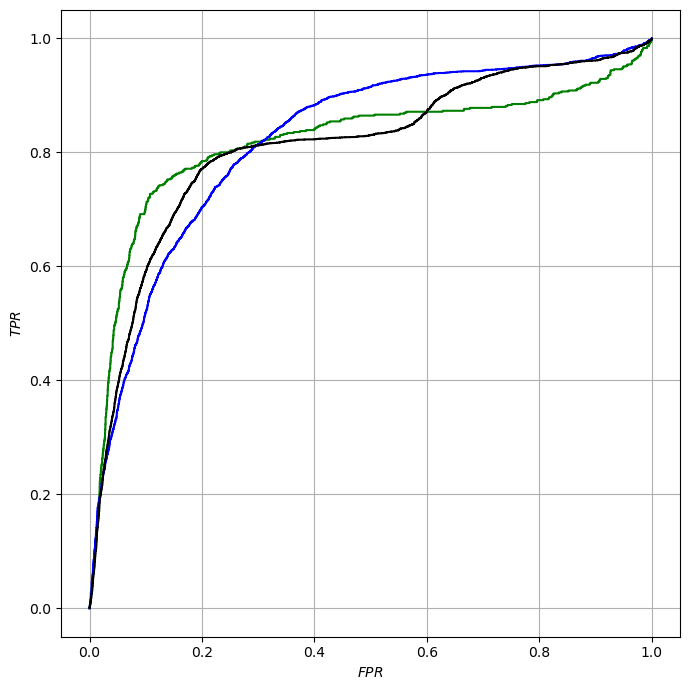

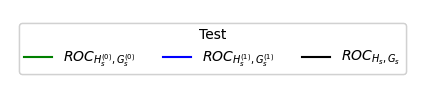

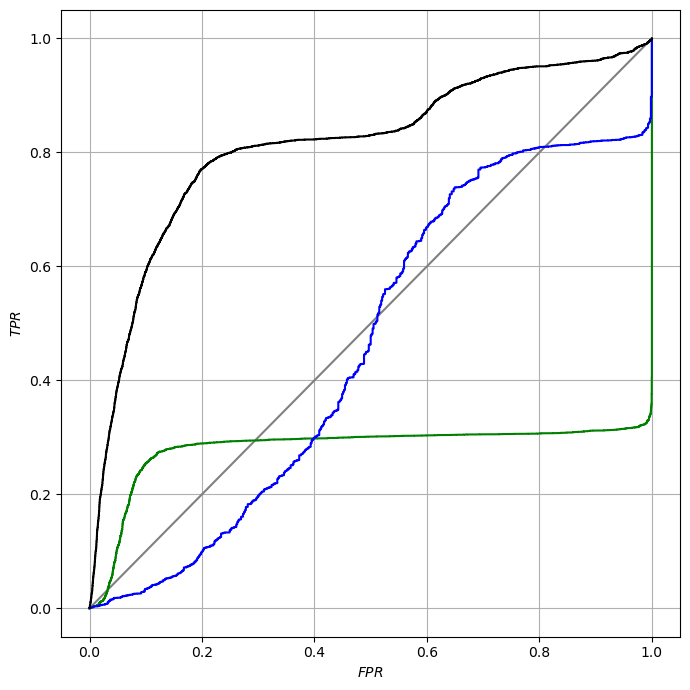

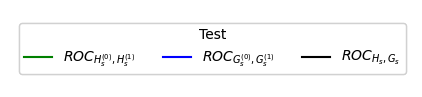

In [21]:
roc_model_adult = load_model("ptw_cons")

# we hardcode a folder where the results are saved
exp_path = pathlib.Path("./output")

if not exp_path.exists():
    exp_path.mkdir()

# need to close an eventually already existing tenserflow session properly as we can't fit another model otherwise
tf.compat.v1.reset_default_graph()

time_2 = datetime.datetime.now()
roc_model_adult.fit(data_train) # I didn't include the optional parameter about the model folder as I just created a new instance.
time_3 = datetime.datetime.now()

# Write a logging file with important info
with (exp_path / "log.txt").open("wt") as f:
    f.write("db_name: {}\n".format("adult"))
    f.write("time_to_load: {}\n".format(time_2-time_1))
    f.write("time_to_fit: {}\n".format(time_3-time_2))

# Save the model
roc_model_adult.save_model(exp_path)

s_test = np.array(roc_model_adult.score(X_test)).ravel().astype(float)
s_train = np.array(roc_model_adult.score(X_train)).ravel().astype(float)

# Define a path on where to save the results
path_analysis = pathlib.Path("./evaluation")

if not path_analysis.exists():
        path_analysis.mkdir()

# 1. Plot ROC curves for all problems on the same plot
plot_roc_sec3(path_analysis,
                (s_train, Y_train, Z_train), (s_test, Y_test, Z_test))

# 2. Other view on ROCs
plot_roc_sec4(path_analysis,
                (s_train, Y_train, Z_train), (s_test, Y_test, Z_test))

# 3. German credit dataset

In [22]:
time_1 = datetime.datetime.now()

data_train, data_test = load_db_by_name("german")
X_train, Y_train, Z_train = data_train
X_test, Y_test, Z_test = data_test

# Print the first few rows of each part of the data to verify it's loaded correctly
print("First few rows of X_train:")
print(X_train[:3])

print("\nFirst few values of Z_train (sensitive attributes):")
print(Z_train[:3])

print("\nFirst few labels of y_train:")
print(Y_train[:3])

print("\nFirst few rows of X_test:")
print(X_test[:3])

print("\nFirst few values of Z_test (sensitive attributes):")
print(Z_test[:3])

print("\nFirst few labels of y_test:")
print(Y_test[:3])

First few rows of X_train:
[[ 3.29708155  1.19991221  0.03119565  1.04450868  2.4061873   1.01777726
  -0.40973554  1.65478632 -0.60430763 -0.25543363 -0.82289054 -0.21389632
  -0.22331316 -1.05131497  3.15577314 -0.64298333 -0.55809982 -0.34251779
  -0.11250879 -0.45457288 -0.62747767 -0.11807497 -0.15597367 -0.22021079
  -0.09395338  3.02102338  0.82931521 -0.33794397 -0.27435163 -0.226381
  -0.47841263 -0.26904657 -0.44855457 -0.71374643 -0.46056619  1.72058015
  -0.21068086 -0.68205679  0.90453403 -0.31448545  0.33333333 -0.21068086
  -0.24699789 -0.61588176 -0.55424682 -0.7117523   2.34607439 -0.39716798
  -0.21389632  0.46852129 -0.46056619  0.62941287 -0.34931309 -0.14734777
  -0.48038446  0.76430257 -0.43643578 -1.1751393   1.1751393   0.19044535
  -0.19044535]
 [-0.00805096 -0.35962991 -0.86010854 -1.67144022 -0.22436411 -0.71093146
  -0.40973554 -0.60430763 -0.60430763  3.91491132 -0.82289054 -0.21389632
  -0.22331316 -1.05131497 -0.31687956  1.55525028 -0.55809982 -0.3425177

## 3.1 Background Negative Subgroup Positive (BNSP) AUC fairness

Parameters:
n_iter : 150000
n_batch : 1000
display_step : 500
lr : 0.001
adapt_step : 0.01
momentum : 0.9
default_c : 0.0
default_var_init : 0.01
reg : 0.001
optimizer : momentum
weight_fun : softmax
cooling_c : 0
balanced : 0
validation_size : 0.1
coef_lagrange : 1.0
net_depth : 3
use_inc_auc_train : 1
n_incomplete_train : 1000
use_inc_auc_valid : 1
n_incomplete_valid : 10000
c : 0.0
Number of features: 61
Size of the train set: 720
Size of the validation set: 80


/opt/anaconda3/envs/fml_tf_env_v2/lib/python3.8/site-packages/keras/legacy_tf_layers/normalization.py:423: UserWarning: `tf.layers.batch_normalization` is deprecated and will be removed in a future version. Please use `tf.keras.layers.BatchNormalization` instead. In particular, `tf.control_dependencies(tf.GraphKeys.UPDATE_OPS)` should not be used (consult the `tf.keras.layers.BatchNormalization` documentation).
  warnings.warn(
/opt/anaconda3/envs/fml_tf_env_v2/lib/python3.8/site-packages/keras/engine/base_layer_v1.py:1676: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


dt |  r_cost  |   cost   |   auc    |  r_auc   |  f_auc   | r_f_auc  |    l2    |    c    
tr | +0.50056 | +0.50300 | +0.49200 | +0.50000 | +0.01100 | +0.00000 | +0.56022 | +0.00000
te | +0.50056 | +0.54930 | +0.42330 | +0.50000 | +0.12600 | +0.00000 | +0.56022 | +0.00000
Iter   0   ---------- 9/5/24 - 12:35:53 -----
dt |  r_cost  |   cost   |   auc    |  r_auc   |  f_auc   | r_f_auc  |    l2    |    c    
tr | +0.50055 | +0.28500 | +0.27300 | +0.49999 | +0.01200 | +0.00000 | +0.55691 | +0.01000
te | +0.50055 | +0.22170 | +0.31270 | +0.49999 | -0.09100 | -0.00000 | +0.55691 | +0.01000
Iter  500  ---------- 9/5/24 - 12:35:54 -----
dt |  r_cost  |   cost   |   auc    |  r_auc   |  f_auc   | r_f_auc  |    l2    |    c    
tr | +0.50044 | +0.13900 | +0.18900 | +0.49987 | -0.05000 | -0.00002 | +0.57378 | +0.00000
te | +0.50048 | +0.12060 | +0.23620 | +0.49991 | -0.11560 | -0.00005 | +0.57378 | +0.00000
Iter 1000  ---------- 9/5/24 - 12:35:55 -----
dt |  r_cost  |   cost   |   auc    |  r_au

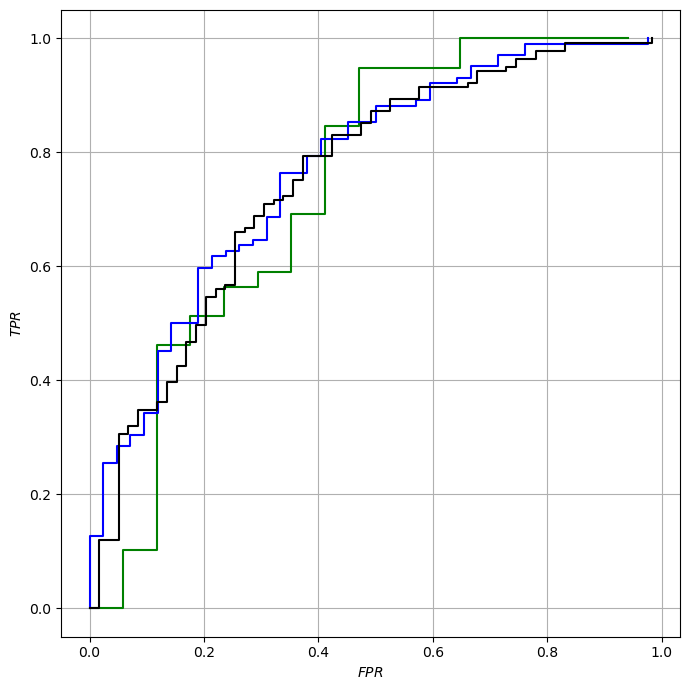

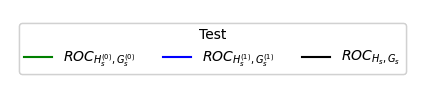

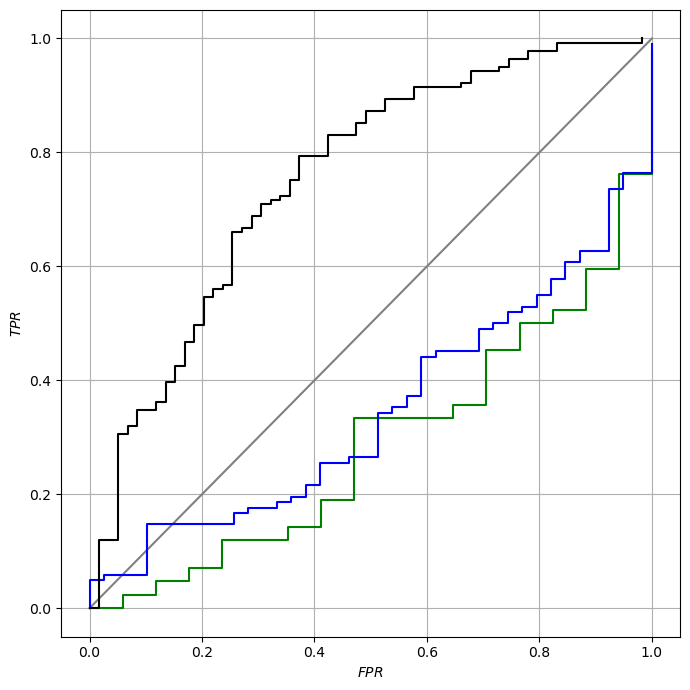

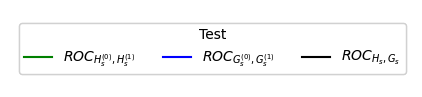

In [23]:
bpsn_model_credit = load_model("auc_cons_bpsn")

# we hardcode a folder where the results are saved
exp_path = pathlib.Path("./output")

if not exp_path.exists():
    exp_path.mkdir()

# need to close an eventually already existing tenserflow session properly as we can't fit another model otherwise
tf.compat.v1.reset_default_graph()

time_2 = datetime.datetime.now()
bpsn_model_credit.fit(data_train) # I didn't include the optional parameter about the model folder as I just created a new instance.
time_3 = datetime.datetime.now()

# Write a logging file with important info
with (exp_path / "log.txt").open("wt") as f:
    f.write("db_name: {}\n".format("adult"))
    f.write("time_to_load: {}\n".format(time_2-time_1))
    f.write("time_to_fit: {}\n".format(time_3-time_2))

# Save the model
bpsn_model_credit.save_model(exp_path)

s_test = np.array(bpsn_model_credit.score(X_test)).ravel().astype(float)
s_train = np.array(bpsn_model_credit.score(X_train)).ravel().astype(float)

# Define a path on where to save the results
path_analysis = pathlib.Path("./evaluation")

if not path_analysis.exists():
        path_analysis.mkdir()

# 1. Plot ROC curves for all problems on the same plot
plot_roc_sec3(path_analysis,
                (s_train, Y_train, Z_train), (s_test, Y_test, Z_test))

# 2. Other view on ROCs
plot_roc_sec4(path_analysis,
                (s_train, Y_train, Z_train), (s_test, Y_test, Z_test))

The AUC for the test (black ROC curve) set is: 0.755


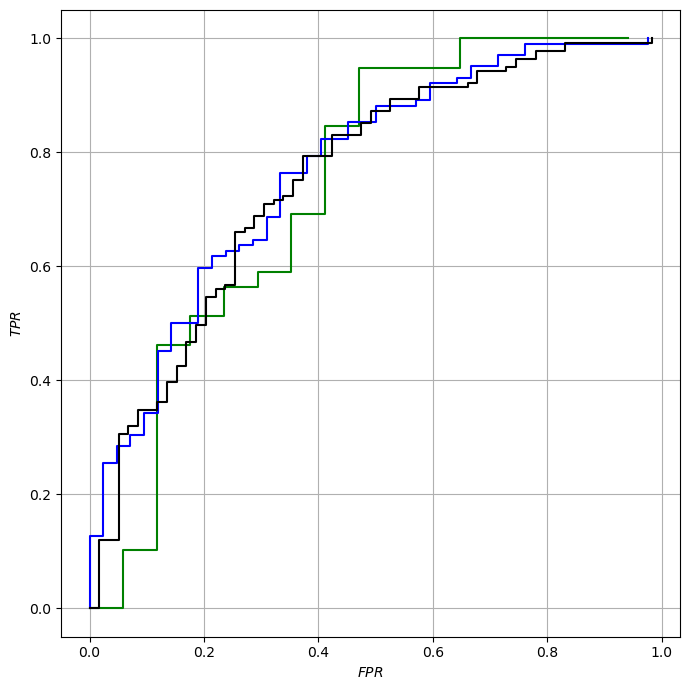

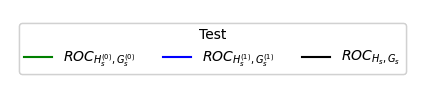

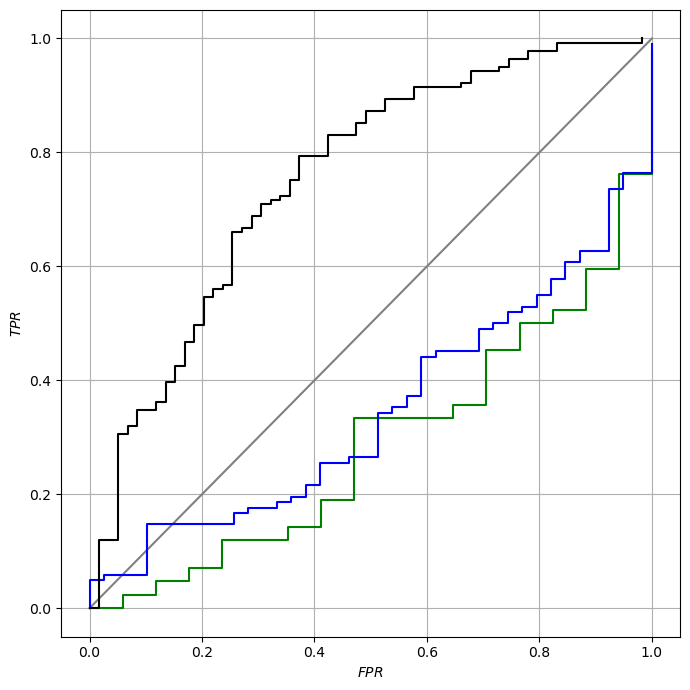

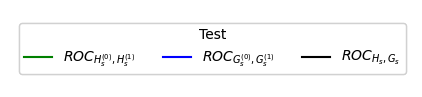

In [24]:
# 1. Plot ROC curves for all problems on the same plot
plot_roc_sec3(path_analysis,
                (s_train, Y_train, Z_train), (s_test, Y_test, Z_test))

# 2. Other view on ROCs
plot_roc_sec4(path_analysis,
                (s_train, Y_train, Z_train), (s_test, Y_test, Z_test))

## 3.2 ROC based fairness

Parameters:
mon_pts : {-1: [0.25], 1: [0.25]}
adapt_step_t : 0.01
n_iter : 150000
n_batch : 1000
display_step : 500
lr : 0.001
adapt_step : 0.01
momentum : 0.9
default_c : 0.0
default_var_init : 0.01
reg : 0.001
optimizer : momentum
weight_fun : softmax
cooling_c : 0
balanced : 0
validation_size : 0.1
coef_lagrange : 1.0
net_depth : 3
use_inc_auc_train : 1
n_incomplete_train : 1000
use_inc_auc_valid : 1
n_incomplete_valid : 10000
c : 0.0
Number of features: 61
Size of the train set: 720
Size of the validation set: 80


/opt/anaconda3/envs/fml_tf_env_v2/lib/python3.8/site-packages/keras/legacy_tf_layers/normalization.py:423: UserWarning: `tf.layers.batch_normalization` is deprecated and will be removed in a future version. Please use `tf.keras.layers.BatchNormalization` instead. In particular, `tf.control_dependencies(tf.GraphKeys.UPDATE_OPS)` should not be used (consult the `tf.keras.layers.BatchNormalization` documentation).
  warnings.warn(
/opt/anaconda3/envs/fml_tf_env_v2/lib/python3.8/site-packages/keras/engine/base_layer_v1.py:1676: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


dt |  r_cost  |   cost   |   auc    |  r_auc   |    l2    |  mean_c  |  var_c   |  dFPR_m  |  dFPR_v  |  dTPR_m  |  dTPR_v 
tr | +0.50059 | +0.47600 | +0.47600 | +0.50000 | +0.58649 | +0.00000 | +0.00000 | +0.25000 | +0.00000 | +0.25000 | +0.00000
te | +0.50059 | +0.50020 | +0.50020 | +0.50000 | +0.58649 | +0.00000 | +0.00000 | +0.25000 | +0.00000 | +0.25000 | +0.00000
c: +0.00000 | +0.00000
biases: +0.00000 | +0.00000
FPRs: +0.00000 | +0.00000
TPRs: +0.00000 | +0.00000
Iter   0   ---------- 9/5/24 - 12:39:29 -----
dt |  r_cost  |   cost   |   auc    |  r_auc   |    l2    |  mean_c  |  var_c   |  dFPR_m  |  dFPR_v  |  dTPR_m  |  dTPR_v 
tr | +0.50057 | +0.24500 | +0.24500 | +0.49999 | +0.58309 | +0.00000 | +0.00000 | +0.25000 | +0.00000 | +0.25000 | +0.00000
te | +0.50058 | +0.33930 | +0.33930 | +0.49999 | +0.58309 | +0.00000 | +0.00000 | +0.25000 | +0.00000 | +0.25000 | +0.00000
c: +0.00000 | +0.00000
biases: -0.01000 | -0.01000
FPRs: +0.00000 | +0.00000
TPRs: +0.00000 | +0.00000
Iter

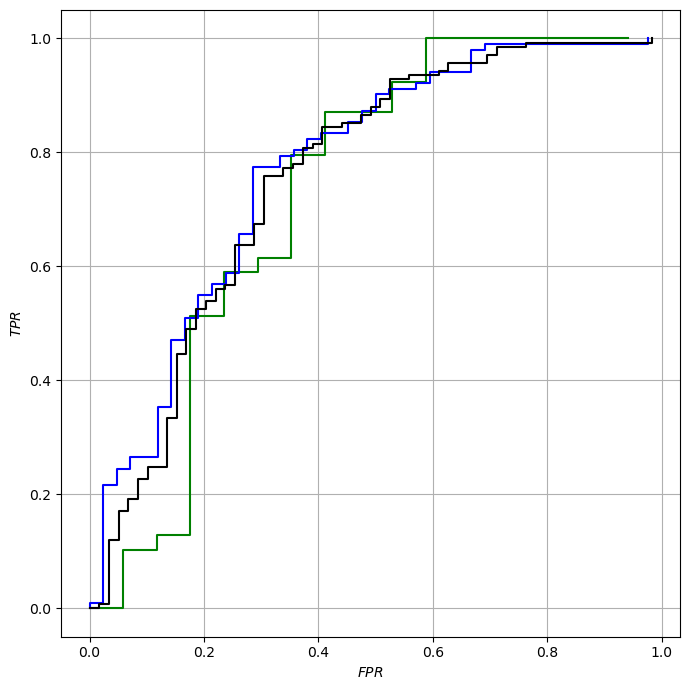

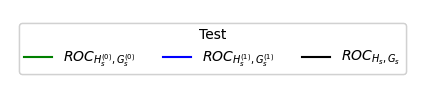

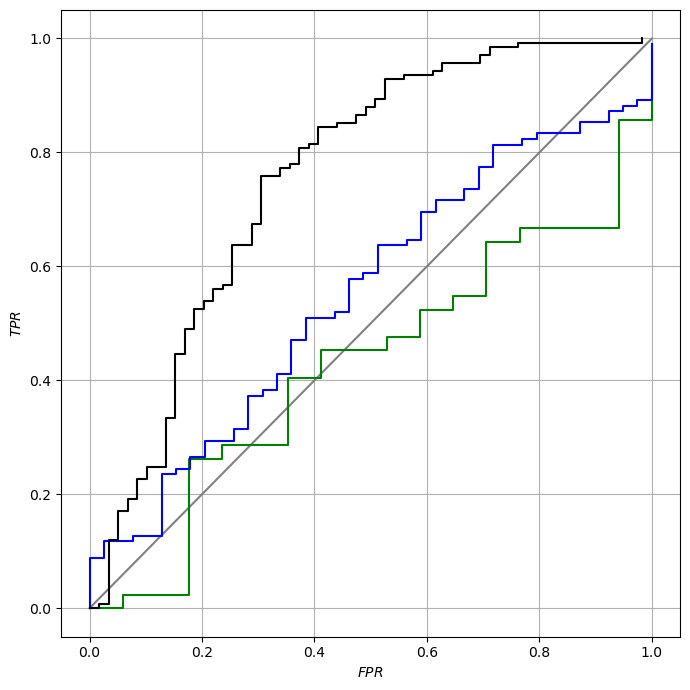

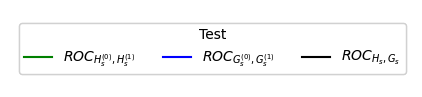

In [25]:
roc_model_credit = load_model("ptw_cons")

# we hardcode a folder where the results are saved
exp_path = pathlib.Path("./output")

if not exp_path.exists():
    exp_path.mkdir()

# need to close an eventually already existing tenserflow session properly as we can't fit another model otherwise
tf.compat.v1.reset_default_graph()

time_2 = datetime.datetime.now()
roc_model_credit.fit(data_train) # I didn't include the optional parameter about the model folder as I just created a new instance.
time_3 = datetime.datetime.now()

# Write a logging file with important info
with (exp_path / "log.txt").open("wt") as f:
    f.write("db_name: {}\n".format("adult"))
    f.write("time_to_load: {}\n".format(time_2-time_1))
    f.write("time_to_fit: {}\n".format(time_3-time_2))

# Save the model
roc_model_credit.save_model(exp_path)

s_test = np.array(roc_model_credit.score(X_test)).ravel().astype(float)
s_train = np.array(roc_model_credit.score(X_train)).ravel().astype(float)

# Define a path on where to save the results
path_analysis = pathlib.Path("./evaluation")

if not path_analysis.exists():
        path_analysis.mkdir()

# 1. Plot ROC curves for all problems on the same plot
plot_roc_sec3(path_analysis,
                (s_train, Y_train, Z_train), (s_test, Y_test, Z_test))

# 2. Other view on ROCs
plot_roc_sec4(path_analysis,
                (s_train, Y_train, Z_train), (s_test, Y_test, Z_test))